# 🚀 ITSM Ticket Similarity - Real ServiceNow Data Training

**Model:** `sentence-transformers/all-mpnet-base-v2` (768-dim embeddings)  
**Data:** Real ServiceNow incidents (Mar 2024 → Sep 2025, ~30K+ tickets)  
**Use Case:** Find similar tickets, detect duplicates, assist routing

## Key Differences from Dummy Data Pipeline
1. **No Short Description** — Real data only has `Description` field
2. **Rich vocabulary** — 10K+ unique terms vs 111 in dummy data
3. **Realistic metrics expected** — ROC-AUC 0.85-0.90, Spearman 0.65-0.75
4. **No Resolution notes in training text** — Avoids data leakage for new tickets

# 1. Environment Setup

In [4]:
import os, sys, subprocess
from pathlib import Path

# Environment variables to suppress warnings
os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_SILENT'] = 'true'
os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Install required packages
def ensure_packages():
    try:
        import importlib.metadata as importlib_metadata
    except ImportError:
        import importlib_metadata
    
    required = {
        'sentence-transformers': 'sentence-transformers>=2.2.2',
        'torch': 'torch',
        'scikit-learn': 'scikit-learn>=1.3.0',
        'pandas': 'pandas',
        'numpy': 'numpy>=1.24.0',
        'tqdm': 'tqdm',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn',
    }
    
    missing = []
    for name, spec in required.items():
        try:
            importlib_metadata.version(name)
        except importlib_metadata.PackageNotFoundError:
            missing.append(spec)
    
    if missing:
        print(f'📦 Installing: {", ".join(missing)}')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', *missing])
    else:
        print('✅ All packages installed')

ensure_packages()

✅ All packages installed


# 2. Configuration

In [5]:
import random
import numpy as np
import torch
import logging

# Simple logging
def log(msg, level=logging.INFO):
    print(msg)

# --- CONFIGURATION ---
CONFIG = {
    # Model
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/real_servicenow_finetuned',
    
    # Data
    'source_data': 'data_new/incident ticket volume from 18th Mar\'24 till date 4th Sep\'25 @5PM SGT.csv',
    
    # Training hyperparameters
    'epochs': 4,              # Real data needs fewer epochs (more signal)
    'batch_size': 16,         # Will auto-reduce for MPS if needed
    'lr': 2e-5,
    'max_seq_length': 384,
    'warmup_ratio': 0.1,
    
    # Pair generation
    'num_pairs': 50000,       # 50K pairs for real data
    'pos_ratio': 0.35,        # 35% positives
    'hard_neg_ratio': 0.35,   # 35% hard negatives (same category, low similarity)
    'easy_neg_ratio': 0.30,   # 30% easy negatives (cross-category)
    'pos_tfidf_threshold': 0.35,   # Lower threshold for real data (more variety)
    'neg_tfidf_threshold': 0.20,   # Upper bound for negatives
    
    # Data splits
    'eval_split': 0.15,
    'holdout_split': 0.10,
    
    # Minimum text length (filter short descriptions)
    'min_text_length': 25,
    
    # Seed
    'seed': 42
}

# Set seeds for reproducibility
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

# Device detection: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.cuda.manual_seed_all(CONFIG['seed'])
    log(f"🚀 CUDA Detected: {torch.cuda.get_device_name(0)}")
    # Keep batch_size=16 for CUDA
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = 'mps'
    torch.mps.manual_seed(CONFIG['seed'])
    log("🍎 MPS (Apple Silicon) Detected")
    CONFIG['batch_size'] = 8  # Reduce for MPS memory
else:
    DEVICE = 'cpu'
    log("⚠️ No GPU detected. Running on CPU.")
    CONFIG['batch_size'] = 8

log(f"📊 Device: {DEVICE}, Batch Size: {CONFIG['batch_size']}")

🚀 CUDA Detected: NVIDIA GeForce RTX 2080 SUPER
📊 Device: cuda, Batch Size: 16


# 3. Data Loading & Preprocessing

Load real ServiceNow incident data. Key differences from dummy data:
- Only `Description` field (no Short Description)
- Multi-line text with embedded newlines
- Rich technical vocabulary

In [6]:
import pandas as pd
import re
from pathlib import Path

def load_and_preprocess_real_data(config):
    """
    Load and preprocess real ServiceNow incident data.
    
    Key differences from dummy data:
    - Only 'Description' column (no 'Short Description')
    - Real data has multi-line descriptions with embedded newlines
    - Richer vocabulary and more varied text
    """
    source_path = Path(config['source_data'])
    
    # Debug: Show absolute path
    log(f"🔍 Looking for data file:")
    log(f"   Configured path: {config['source_data']}")
    log(f"   Absolute path: {source_path.resolve()}")
    log(f"   Current working directory: {Path.cwd()}")
    log(f"   File exists: {source_path.exists()}")
    
    if not source_path.exists():
        raise FileNotFoundError(f"Data file not found: {source_path.resolve()}")
    
    log(f"📂 Loading real ServiceNow data from: {source_path}")
    
    # Load CSV - handle multi-line fields
    df = pd.read_csv(source_path, encoding='utf-8', on_bad_lines='skip')
    initial_count = len(df)
    log(f"📊 Loaded {initial_count:,} raw records")
    
    # Check required columns
    required_cols = ['Number', 'Description', 'Category', 'Subcategory', 
                     'Service', 'Service offering', 'Assignment group']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        log(f"⚠️ Missing columns: {missing_cols}")
        # Use available columns
        required_cols = [col for col in required_cols if col in df.columns]
    
    log(f"✅ Available columns: {list(df.columns)}")
    
    # Clean text function
    def clean_text(text):
        if pd.isna(text) or text is None:
            return ""
        text = str(text).strip()
        # Normalize whitespace (collapse multiple spaces/newlines)
        text = re.sub(r'\s+', ' ', text)
        # Remove common boilerplate
        text = re.sub(r'Note\s*:\s*This is an automated.*?\.', '', text, flags=re.IGNORECASE)
        return text.strip()
    
    # Clean Description
    df['Description'] = df['Description'].apply(clean_text)
    
    # Fill NA for context columns
    context_cols = ['Category', 'Subcategory', 'Service', 'Service offering', 'Assignment group']
    for col in context_cols:
        if col in df.columns:
            df[col] = df[col].fillna('').astype(str).str.strip().str.lower()
    
    # Build contextual text representation
    # Format: "Description (Context: [Service|Offering] [Category|Subcategory] Group: X)"
    def build_context(row):
        parts = []
        
        # Service context
        service_parts = []
        if row.get('Service', ''):
            service_parts.append(row['Service'])
        if row.get('Service offering', ''):
            service_parts.append(row['Service offering'])
        if service_parts:
            parts.append(f"[{' | '.join(service_parts)}]")
        
        # Category context
        cat_parts = []
        if row.get('Category', ''):
            cat_parts.append(row['Category'])
        if row.get('Subcategory', ''):
            cat_parts.append(row['Subcategory'])
        if cat_parts:
            parts.append(f"[{' | '.join(cat_parts)}]")
        
        # Assignment group
        if row.get('Assignment group', ''):
            parts.append(f"Group: {row['Assignment group']}")
        
        return ' '.join(parts) if parts else ''
    
    # Build full text: Description + Context suffix
    df['context'] = df.apply(build_context, axis=1)
    df['text'] = df.apply(
        lambda row: f"{row['Description']} (Context: {row['context']})" if row['context'] else row['Description'],
        axis=1
    )
    
    # Filter out short/empty descriptions
    df = df[df['Description'].str.len() >= config['min_text_length']].copy()
    log(f"📉 After filtering short descriptions: {len(df):,} records (dropped {initial_count - len(df):,})")
    
    # Create category_id for stratified splitting
    if 'Category' in df.columns and 'Subcategory' in df.columns:
        df['category_id'] = df.groupby(['Category', 'Subcategory']).ngroup()
    else:
        df['category_id'] = 0
    
    # Reset index
    df = df.reset_index(drop=True)
    
    # Summary stats
    log(f"\n📊 Data Summary:")
    log(f"   Total records: {len(df):,}")
    log(f"   Unique categories: {df['category_id'].nunique()}")
    log(f"   Avg text length: {df['text'].str.len().mean():.0f} chars")
    log(f"   Min text length: {df['text'].str.len().min()} chars")
    log(f"   Max text length: {df['text'].str.len().max()} chars")
    
    # Sample text
    log(f"\n📝 Sample preprocessed text:")
    log(f"   '{df['text'].iloc[0][:200]}...'")
    
    return df

# Load the data
df_incidents = load_and_preprocess_real_data(CONFIG)
print(f"\n✅ Loaded {len(df_incidents):,} incidents ready for training")

🔍 Looking for data file:
   Configured path: data_new/incident ticket volume from 18th Mar'24 till date 4th Sep'25 @5PM SGT.csv
   Absolute path: C:\Users\donov\Downloads\nexustism\nexustism\data_new\incident ticket volume from 18th Mar'24 till date 4th Sep'25 @5PM SGT.csv
   Current working directory: c:\Users\donov\Downloads\nexustism\nexustism
   File exists: True
📂 Loading real ServiceNow data from: data_new\incident ticket volume from 18th Mar'24 till date 4th Sep'25 @5PM SGT.csv
📊 Loaded 10,633 raw records
✅ Available columns: ['Number', 'Description', 'Opened by', 'Company', 'ITSM Department', 'Created', 'Urgency', 'Impact', 'Priority', 'Assignment group', 'Assigned to', 'State', 'Service', 'Service offering', 'Closed', 'Closed by', 'Category', 'Subcategory', 'Resolution code', 'Resolution notes', 'User input', 'Comments and Work notes', 'Manday Effort (hrs)', 'Ticket Type', 'AMS Domain', 'AMS System Type', 'AMS Category Type', 'AMS Service Type', 'AMS Business Related', 'AMS IT

# 4. Data Splitting

Split into Train / Eval / Holdout sets with stratification by category.

In [7]:
from sklearn.model_selection import train_test_split

def split_data(df, config):
    """
    Three-way split: Train / Eval / Holdout
    - Holdout is completely unseen (for adversarial diagnostic)
    - Stratified by category to ensure representation
    """
    # Handle rare categories: group categories with <2 samples
    category_counts = df['category_id'].value_counts()
    rare_categories = category_counts[category_counts < 2].index
    
    # Create stratification column: use category_id for common categories, -1 for rare
    df['stratify_col'] = df['category_id'].copy()
    df.loc[df['category_id'].isin(rare_categories), 'stratify_col'] = -1
    
    # Check if we can stratify (need at least 2 samples per class)
    stratify_counts = df['stratify_col'].value_counts()
    can_stratify = all(stratify_counts >= 2)
    
    if can_stratify:
        # First split: separate holdout set (stratified)
        train_eval_df, holdout_df = train_test_split(
            df,
            test_size=config['holdout_split'],
            stratify=df['stratify_col'],
            random_state=config['seed']
        )
        
        # Second split: train/eval from remaining (stratified)
        train_df, eval_df = train_test_split(
            train_eval_df,
            test_size=config['eval_split'],
            stratify=train_eval_df['stratify_col'],
            random_state=config['seed']
        )
        log("✅ Using stratified split")
    else:
        # Fallback: random split without stratification
        log("⚠️ Using random split (categories too imbalanced for stratification)")
        train_eval_df, holdout_df = train_test_split(
            df,
            test_size=config['holdout_split'],
            random_state=config['seed']
        )
        
        train_df, eval_df = train_test_split(
            train_eval_df,
            test_size=config['eval_split'],
            random_state=config['seed']
        )
    
    return train_df, eval_df, holdout_df

# Split the data
train_df, eval_df, holdout_df = split_data(df_incidents, CONFIG)

log(f"📊 Data Splits:")
log(f"   Train:   {len(train_df):,} incidents ({len(train_df)/len(df_incidents)*100:.1f}%)")
log(f"   Eval:    {len(eval_df):,} incidents ({len(eval_df)/len(df_incidents)*100:.1f}%)")
log(f"   Holdout: {len(holdout_df):,} incidents ({len(holdout_df)/len(df_incidents)*100:.1f}%)")

# Check for data leakage
def check_overlap(df1, df2, name1, name2):
    overlap = len(set(df1['Number']) & set(df2['Number']))
    log(f"   {name1} ∩ {name2}: {overlap} incidents")

log(f"\n🔍 Overlap Check:")
check_overlap(train_df, eval_df, "Train", "Eval")
check_overlap(train_df, holdout_df, "Train", "Holdout")
check_overlap(eval_df, holdout_df, "Eval", "Holdout")

✅ Using stratified split
📊 Data Splits:
   Train:   8,021 incidents (76.5%)
   Eval:    1,416 incidents (13.5%)
   Holdout: 1,049 incidents (10.0%)

🔍 Overlap Check:
   Train ∩ Eval: 0 incidents
   Train ∩ Holdout: 0 incidents
   Eval ∩ Holdout: 0 incidents


# 5. Pair Generation

Generate training pairs using TF-IDF similarity mining:
- **35% Positives**: High TF-IDF similarity (> 0.35)
- **35% Hard Negatives**: Same category, low TF-IDF (< 0.20)
- **30% Easy Negatives**: Different category, low TF-IDF

This forces the model to learn semantic content, not just category matching.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import InputExample
from tqdm.auto import tqdm
import gc

class TFIDFSimilarityCalculator:
    """Efficient TF-IDF similarity calculator for large datasets."""
    
    def __init__(self, texts, max_features=15000):
        log("⏳ Building TF-IDF matrix...")
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2),  # Unigrams + bigrams for better matching
            min_df=2,           # Ignore very rare terms
            max_df=0.95         # Ignore very common terms
        )
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)
        log(f"✅ TF-IDF matrix: {self.tfidf_matrix.shape} (vocab size: {len(self.vectorizer.vocabulary_)})")
    
    def similarity(self, idx1, idx2):
        """Compute cosine similarity between two documents."""
        if idx1 >= self.tfidf_matrix.shape[0] or idx2 >= self.tfidf_matrix.shape[0]:
            return 0.0
        vec1 = self.tfidf_matrix[idx1]
        vec2 = self.tfidf_matrix[idx2]
        return (vec1 @ vec2.T).toarray()[0][0]


def generate_training_pairs(df, target_count, config, desc=""):
    """
    Generate training pairs with 35/35/30 split:
    - 35% positives (high TF-IDF similarity)
    - 35% hard negatives (same category, low TF-IDF)
    - 30% easy negatives (cross-category, low TF-IDF)
    """
    df = df.reset_index(drop=True)
    
    # Build TF-IDF for this split
    tfidf_calc = TFIDFSimilarityCalculator(df['text'].tolist())
    
    # Calculate targets
    pos_target = int(target_count * config['pos_ratio'])
    hard_neg_target = int(target_count * config['hard_neg_ratio'])
    easy_neg_target = target_count - pos_target - hard_neg_target
    
    pairs = []
    all_indices = list(df.index)
    
    # Group by category for hard negatives
    category_groups = df.groupby('category_id').indices
    valid_groups = {k: list(v) for k, v in category_groups.items() if len(v) >= 2}
    
    log(f"\n🎯 Generating {target_count:,} pairs for {desc}:")
    log(f"   Target: {pos_target:,} positives, {hard_neg_target:,} hard neg, {easy_neg_target:,} easy neg")
    
    # ============================================
    # 1. POSITIVES: High TF-IDF similarity (> threshold)
    # ============================================
    pbar = tqdm(total=pos_target, desc="Positives (high TF-IDF)")
    attempts, max_attempts = 0, pos_target * 50
    
    while len(pairs) < pos_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        if i1 == i2:
            continue
        
        sim = tfidf_calc.similarity(i1, i2)
        if sim > config['pos_tfidf_threshold']:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=1.0
            ))
            pbar.update(1)
    pbar.close()
    actual_pos = len(pairs)
    
    # ============================================
    # 2. HARD NEGATIVES: Same category, low TF-IDF
    # ============================================
    current_len = len(pairs)
    pbar = tqdm(total=hard_neg_target, desc="Hard Negatives (same cat)")
    attempts, max_attempts = 0, hard_neg_target * 50
    
    while (len(pairs) - current_len) < hard_neg_target and attempts < max_attempts:
        attempts += 1
        if not valid_groups:
            break
        
        # Pick a random category with 2+ members
        gid = random.choice(list(valid_groups.keys()))
        g_indices = valid_groups[gid]
        if len(g_indices) < 2:
            continue
        
        i1, i2 = random.sample(g_indices, 2)
        sim = tfidf_calc.similarity(i1, i2)
        
        if sim < config['neg_tfidf_threshold']:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=0.0
            ))
            pbar.update(1)
    pbar.close()
    actual_hard = len(pairs) - current_len
    
    # ============================================
    # 3. EASY NEGATIVES: Cross-category, low TF-IDF
    # ============================================
    current_len = len(pairs)
    pbar = tqdm(total=easy_neg_target, desc="Easy Negatives (cross-cat)")
    attempts, max_attempts = 0, easy_neg_target * 50
    
    while (len(pairs) - current_len) < easy_neg_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        
        # Must be different categories
        if df.at[i1, 'category_id'] == df.at[i2, 'category_id']:
            continue
        
        sim = tfidf_calc.similarity(i1, i2)
        if sim < config['neg_tfidf_threshold']:
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']],
                label=0.0
            ))
            pbar.update(1)
    pbar.close()
    actual_easy = len(pairs) - current_len
    
    # Summary
    total_pos = sum(1 for p in pairs if p.label == 1.0)
    total_neg = len(pairs) - total_pos
    
    log(f"✅ Generated {len(pairs):,} pairs:")
    log(f"   Positives: {actual_pos:,} ({actual_pos/len(pairs)*100:.1f}%)")
    log(f"   Hard Neg:  {actual_hard:,} ({actual_hard/len(pairs)*100:.1f}%)")
    log(f"   Easy Neg:  {actual_easy:,} ({actual_easy/len(pairs)*100:.1f}%)")
    
    # Clean up TF-IDF to free memory
    del tfidf_calc
    gc.collect()
    
    return pairs

In [ ]:
# Generate pairs for each split
# Scale pair counts based on split sizes
train_pair_count = int(CONFIG['num_pairs'] * 0.75)  # 75% for training
eval_pair_count = int(CONFIG['num_pairs'] * 0.15)   # 15% for eval
holdout_pair_count = int(CONFIG['num_pairs'] * 0.10) # 10% for holdout

train_examples = generate_training_pairs(train_df, train_pair_count, CONFIG, desc="Training")
eval_examples = generate_training_pairs(eval_df, eval_pair_count, CONFIG, desc="Evaluation")
holdout_examples = generate_training_pairs(holdout_df, holdout_pair_count, CONFIG, desc="Holdout")

log(f"\n📦 Final Pair Counts:")
log(f"   Train:   {len(train_examples):,}")
log(f"   Eval:    {len(eval_examples):,}")
log(f"   Holdout: {len(holdout_examples):,}")

⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (8021, 15000) (vocab size: 15000)

🎯 Generating 37,500 pairs for Training:
   Target: 13,125 positives, 13,125 hard neg, 11,250 easy neg


Easy Negatives (cross-cat): 100%|██████████| 11250/11250 [00:03<00:00, 3521.44it/s]


✅ Generated 32,752 pairs:
   Positives: 8,377 (25.6%)
   Hard Neg:  13,125 (40.1%)
   Easy Neg:  11,250 (34.3%)
⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (1416, 5764) (vocab size: 5764)

🎯 Generating 7,500 pairs for Evaluation:
   Target: 2,625 positives, 2,625 hard neg, 2,250 easy neg


Positives (high TF-IDF):  92%|█████████▏| 2422/2625 [00:26<00:02, 96.50it/s] 

KeyboardInterrupt: 

Positives (high TF-IDF):  92%|█████████▏| 2428/2625 [00:43<00:02, 96.50it/s]

# 6. Model Training

Train `all-mpnet-base-v2` with CosineSimilarityLoss on the generated pairs.

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import SentenceEvaluator
from torch.utils.data import DataLoader
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, average_precision_score
from datetime import datetime
import gc

# --- Custom Evaluator ---
class ITSMEvaluator(SentenceEvaluator):
    """Evaluator for ITSM ticket similarity."""
    
    def __init__(self, examples, batch_size=16, name=""):
        self.examples = examples
        self.batch_size = batch_size
        self.name = name
        
        self.texts1 = [ex.texts[0] for ex in examples]
        self.texts2 = [ex.texts[1] for ex in examples]
        self.labels = np.array([ex.label for ex in examples])
        
        self.csv_file = f"{name}_eval_results.csv"
        self.csv_headers = ["epoch", "steps", "spearman", "pearson", "roc_auc", "pr_auc"]
    
    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        model.eval()
        
        # Encode pairs
        emb1 = model.encode(self.texts1, batch_size=self.batch_size, 
                          show_progress_bar=False, convert_to_numpy=True)
        emb2 = model.encode(self.texts2, batch_size=self.batch_size, 
                          show_progress_bar=False, convert_to_numpy=True)
        
        # Compute cosine similarity
        scores = np.sum(emb1 * emb2, axis=1) / (
            np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8
        )
        
        # Compute metrics
        spearman, _ = spearmanr(self.labels, scores)
        pearson, _ = pearsonr(self.labels, scores)
        
        try:
            roc_auc = roc_auc_score(self.labels, scores)
            pr_auc = average_precision_score(self.labels, scores)
        except ValueError:
            roc_auc, pr_auc = 0.0, 0.0
        
        log(f"  [{self.name}] Epoch {epoch}: Spearman={spearman:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
        
        # Save to CSV
        if output_path:
            csv_path = Path(output_path) / self.csv_file
            if not csv_path.exists():
                with open(csv_path, 'w') as f:
                    f.write(','.join(self.csv_headers) + '\n')
            with open(csv_path, 'a') as f:
                f.write(f"{epoch},{steps},{spearman},{pearson},{roc_auc},{pr_auc}\n")
        
        return spearman  # Primary metric


# --- Model Initialization ---
def init_model(config, device):
    """Initialize model with GPU memory management."""
    # Clear GPU memory
    if device == 'cuda':
        torch.cuda.empty_cache()
    elif device == 'mps':
        torch.mps.empty_cache()
    gc.collect()
    
    log(f"🔧 Loading model: {config['model_name']}")
    model = SentenceTransformer(config['model_name'], device=device)
    model.max_seq_length = config['max_seq_length']
    log(f"✅ Model loaded on {device}, max_seq_length={model.max_seq_length}")
    
    return model


# Initialize model
model = init_model(CONFIG, DEVICE)

# Filter to positive pairs only
log(f"📊 Filtering to positive pairs for MultipleNegativesRankingLoss...")
train_positives = [ex for ex in train_examples if ex.label == 1.0]
eval_positives = [ex for ex in eval_examples if ex.label == 1.0]

log(f"   Train positives: {len(train_positives):,} (was {len(train_examples):,} total)")
log(f"   Eval positives:  {len(eval_positives):,} (was {len(eval_examples):,} total)")

# Create DataLoader with ONLY positives
train_dataloader = DataLoader(
    train_positives,  # Changed from train_examples
    shuffle=True,
    batch_size=CONFIG['batch_size'],  # Consider increasing to 16-32 for more in-batch negatives
    num_workers=0,
    pin_memory=(DEVICE in ['cuda', 'mps'])
)

# Use MultipleNegativesRankingLoss instead of CosineSimilarityLoss
from sentence_transformers import losses
train_loss = losses.MultipleNegativesRankingLoss(model)

log(f"🔧 Using MultipleNegativesRankingLoss (in-batch negatives)")
log(f"   Effective negatives per sample: {CONFIG['batch_size'] - 1}")
# Evaluator
evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name="eval")

log(f"\n📊 Training Setup:")
log(f"   Batches per epoch: {len(train_dataloader)}")
log(f"   Total training steps: {len(train_dataloader) * CONFIG['epochs']}")
log(f"   Warmup steps: {int(len(train_dataloader) * CONFIG['epochs'] * CONFIG['warmup_ratio'])}")

🔧 Loading model: sentence-transformers/all-mpnet-base-v2
✅ Model loaded on cuda, max_seq_length=384
📊 Filtering to positive pairs for MultipleNegativesRankingLoss...
   Train positives: 8,377 (was 32,752 total)
   Eval positives:  2,625 (was 7,500 total)
🔧 Using MultipleNegativesRankingLoss (in-batch negatives)
   Effective negatives per sample: 15

📊 Training Setup:
   Batches per epoch: 524
   Total training steps: 2096
   Warmup steps: 209


In [8]:
# --- Training Execution ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_path = Path(CONFIG['output_dir']) / f"real_servicenow_{timestamp}"
save_path.mkdir(parents=True, exist_ok=True)

log(f"\n🚀 Starting Training...")
log(f"   Output: {save_path}")
log(f"   Epochs: {CONFIG['epochs']}")
log(f"   Device: {DEVICE}")

# Calculate warmup steps
total_steps = len(train_dataloader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
eval_steps = max(100, len(train_dataloader) // 2)  # Evaluate twice per epoch

try:
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=CONFIG['epochs'],
        warmup_steps=warmup_steps,
        optimizer_params={'lr': CONFIG['lr']},
        output_path=str(save_path),
        evaluation_steps=eval_steps,
        save_best_model=True,
        show_progress_bar=True
    )
    log("✅ Training complete!")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        log(f"❌ OOM Error: {e}")
        log("💡 Try reducing batch_size or num_pairs")
        raise
    else:
        raise

# Reload best model
log("\n📊 Loading best model for final evaluation...")
best_model = SentenceTransformer(str(save_path), device=DEVICE)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



🚀 Starting Training...
   Output: models\real_servicenow_finetuned\real_servicenow_20251206_1504
   Epochs: 4
   Device: cuda


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss,Evaluator
262,No log,No log,0.814022
524,1.382000,No log,0.818811
786,1.382000,No log,0.818732
1048,1.271000,No log,0.821077
1310,1.271000,No log,0.817626
1572,1.262500,No log,0.820483
1834,1.262500,No log,0.820121
2096,1.230100,No log,0.819950


  [eval] Epoch 0.5: Spearman=0.8140, ROC-AUC=0.9927, PR-AUC=0.9864
  [eval] Epoch 1.0: Spearman=0.8188, ROC-AUC=0.9956, PR-AUC=0.9922
  [eval] Epoch 1.0: Spearman=0.8188, ROC-AUC=0.9956, PR-AUC=0.9922
  [eval] Epoch 1.5: Spearman=0.8187, ROC-AUC=0.9955, PR-AUC=0.9921
  [eval] Epoch 2.0: Spearman=0.8211, ROC-AUC=0.9969, PR-AUC=0.9943
  [eval] Epoch 2.0: Spearman=0.8211, ROC-AUC=0.9969, PR-AUC=0.9943
  [eval] Epoch 2.5: Spearman=0.8176, ROC-AUC=0.9948, PR-AUC=0.9909
  [eval] Epoch 3.0: Spearman=0.8205, ROC-AUC=0.9966, PR-AUC=0.9939
  [eval] Epoch 3.0: Spearman=0.8205, ROC-AUC=0.9966, PR-AUC=0.9939
  [eval] Epoch 3.5: Spearman=0.8201, ROC-AUC=0.9963, PR-AUC=0.9934
  [eval] Epoch 4.0: Spearman=0.8200, ROC-AUC=0.9962, PR-AUC=0.9933
  [eval] Epoch 4.0: Spearman=0.8200, ROC-AUC=0.9962, PR-AUC=0.9933
✅ Training complete!

📊 Loading best model for final evaluation...


# 7. Evaluation & Visualization

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def comprehensive_eval(examples, model, name=""):
    """Run comprehensive evaluation on a set of pairs."""
    texts1 = [ex.texts[0] for ex in examples]
    texts2 = [ex.texts[1] for ex in examples]
    labels = np.array([ex.label for ex in examples])
    
    # Encode
    log(f"⏳ Encoding {len(examples)} pairs for {name}...")
    emb1 = model.encode(texts1, batch_size=CONFIG['batch_size'], 
                       show_progress_bar=True, convert_to_numpy=True)
    emb2 = model.encode(texts2, batch_size=CONFIG['batch_size'], 
                       show_progress_bar=True, convert_to_numpy=True)
    
    # Cosine similarity
    scores = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1) + 1e-8
    )
    
    # Metrics
    spearman, _ = spearmanr(labels, scores)
    pearson, _ = pearsonr(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    pr_auc = average_precision_score(labels, scores)
    
    # Find best threshold
    fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_idx-1] if 0 < best_idx < len(pr_thresholds)+1 else 0.5
    
    # Metrics at best threshold
    preds = (scores >= best_threshold).astype(int)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    
    log(f"\n📊 {name} Results:")
    log(f"   Spearman:  {spearman:.4f}")
    log(f"   Pearson:   {pearson:.4f}")
    log(f"   ROC-AUC:   {roc_auc:.4f}")
    log(f"   PR-AUC:    {pr_auc:.4f}")
    log(f"   Best Threshold: {best_threshold:.3f}")
    log(f"   F1 @ best: {f1:.4f}")
    log(f"   Precision: {prec:.4f}")
    log(f"   Recall:    {rec:.4f}")
    log(f"   Accuracy:  {acc:.4f}")
    
    return {
        'labels': labels, 'scores': scores,
        'spearman': spearman, 'pearson': pearson,
        'roc_auc': roc_auc, 'pr_auc': pr_auc,
        'fpr': fpr, 'tpr': tpr,
        'precision': precision, 'recall': recall,
        'best_threshold': best_threshold,
        'f1': f1, 'prec': prec, 'rec': rec, 'acc': acc,
        'cm': cm
    }

# Evaluate on all sets
log("="*60)
log("📈 FINAL EVALUATION")
log("="*60)

eval_results = comprehensive_eval(eval_examples, best_model, "Eval Set")
holdout_results = comprehensive_eval(holdout_examples, best_model, "Holdout Set")

📈 FINAL EVALUATION
⏳ Encoding 7500 pairs for Eval Set...


Batches: 100%|██████████| 469/469 [03:55<00:00,  1.99it/s]



📊 Eval Set Results:
   Spearman:  0.8211
   Pearson:   0.8621
   ROC-AUC:   0.9969
   PR-AUC:    0.9943
   Best Threshold: 0.744
   F1 @ best: 0.9693
   Precision: 0.9580
   Recall:    0.9810
   Accuracy:  0.9783
⏳ Encoding 5000 pairs for Holdout Set...


Batches: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


📊 Holdout Set Results:
   Spearman:  0.8228
   Pearson:   0.8653
   ROC-AUC:   0.9980
   PR-AUC:    0.9965
   Best Threshold: 0.741
   F1 @ best: 0.9732
   Precision: 0.9615
   Recall:    0.9851
   Accuracy:  0.9810


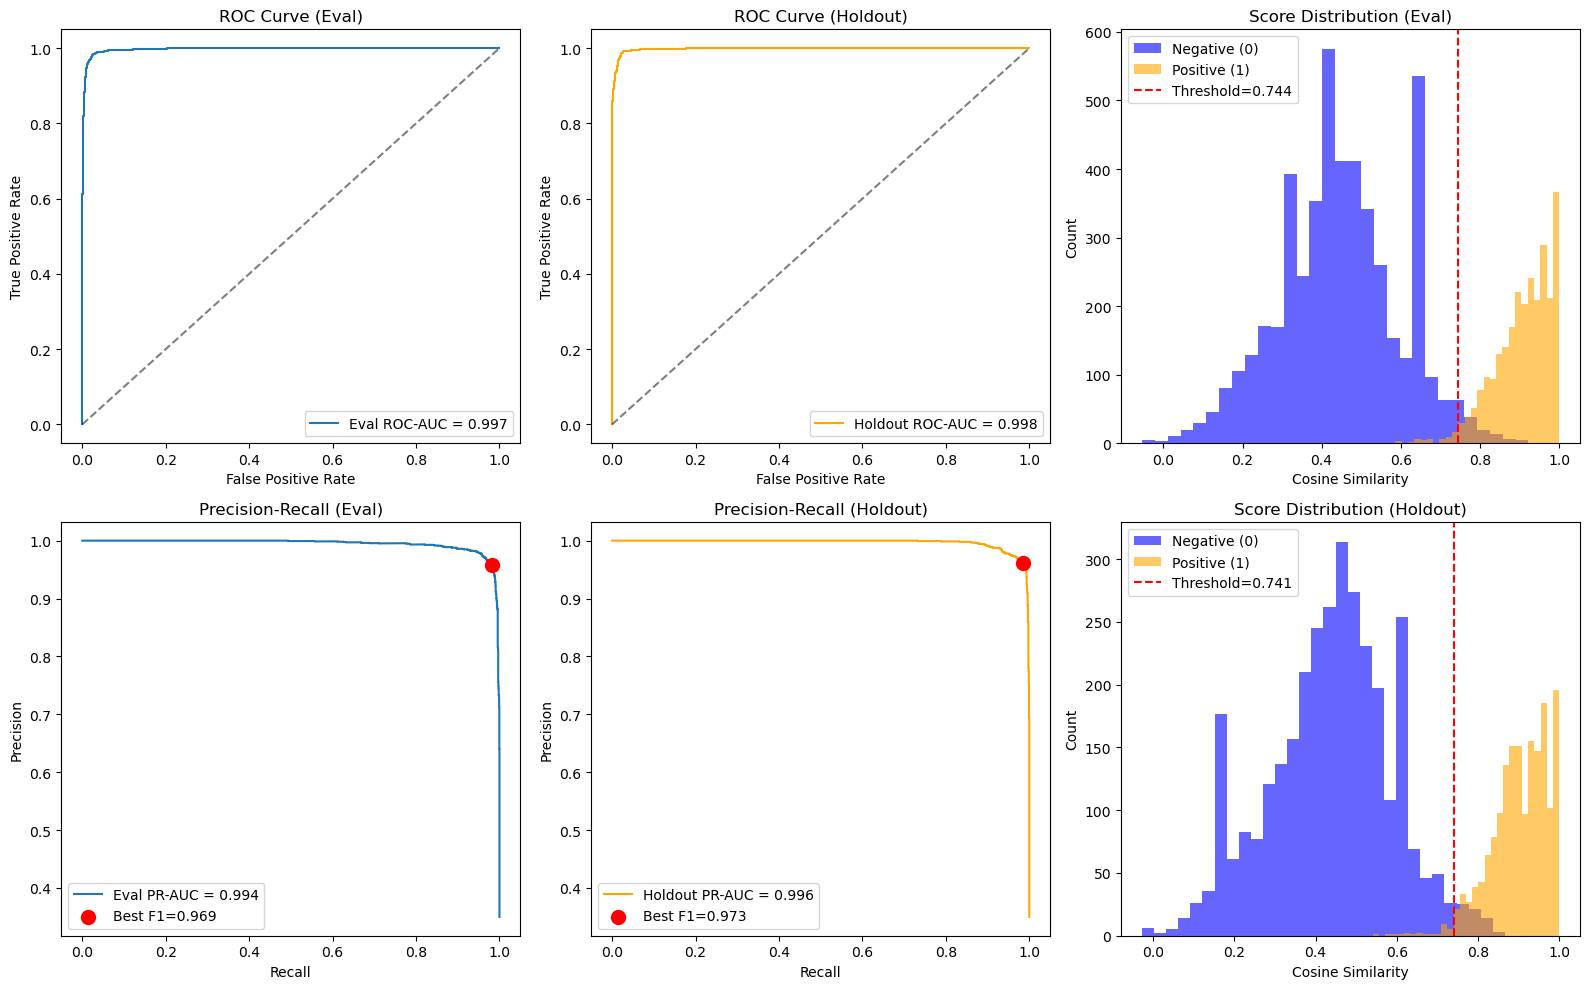


📊 Plots saved to models\real_servicenow_finetuned\real_servicenow_20251206_1504\evaluation_plots.png


In [10]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# ROC Curves
axes[0,0].plot(eval_results['fpr'], eval_results['tpr'], 
               label=f"Eval ROC-AUC = {eval_results['roc_auc']:.3f}")
axes[0,0].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0,0].set_title('ROC Curve (Eval)')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].legend()

axes[0,1].plot(holdout_results['fpr'], holdout_results['tpr'], 
               label=f"Holdout ROC-AUC = {holdout_results['roc_auc']:.3f}", color='orange')
axes[0,1].plot([0,1], [0,1], 'k--', alpha=0.5)
axes[0,1].set_title('ROC Curve (Holdout)')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].legend()

# PR Curves
axes[1,0].plot(eval_results['recall'], eval_results['precision'], 
               label=f"Eval PR-AUC = {eval_results['pr_auc']:.3f}")
axes[1,0].scatter([eval_results['rec']], [eval_results['prec']], 
                  color='red', s=100, zorder=5,
                  label=f"Best F1={eval_results['f1']:.3f}")
axes[1,0].set_title('Precision-Recall (Eval)')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()

axes[1,1].plot(holdout_results['recall'], holdout_results['precision'], 
               label=f"Holdout PR-AUC = {holdout_results['pr_auc']:.3f}", color='orange')
axes[1,1].scatter([holdout_results['rec']], [holdout_results['prec']], 
                  color='red', s=100, zorder=5,
                  label=f"Best F1={holdout_results['f1']:.3f}")
axes[1,1].set_title('Precision-Recall (Holdout)')
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].legend()

# Score Distributions
for idx, (results, name) in enumerate([(eval_results, 'Eval'), (holdout_results, 'Holdout')]):
    ax = axes[idx, 2]
    neg_scores = results['scores'][results['labels'] == 0]
    pos_scores = results['scores'][results['labels'] == 1]
    
    ax.hist(neg_scores, bins=30, alpha=0.6, label='Negative (0)', color='blue')
    ax.hist(pos_scores, bins=30, alpha=0.6, label='Positive (1)', color='orange')
    ax.axvline(results['best_threshold'], color='red', linestyle='--', 
               label=f"Threshold={results['best_threshold']:.3f}")
    ax.set_title(f'Score Distribution ({name})')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout()
plt.savefig(save_path / 'evaluation_plots.png', dpi=150)
plt.show()

log(f"\n📊 Plots saved to {save_path / 'evaluation_plots.png'}")

# 8. Adversarial Diagnostic

**Critical validation**: Test if the model learned semantic content or is exploiting category shortcuts.

- **Hard Positives**: Cross-category pairs with HIGH content similarity
- **Hard Negatives**: Same-category pairs with LOW content similarity

**Pass Criteria**: ROC-AUC ≥ 0.70 AND F1 ≥ 0.65

In [11]:
log("="*60)
log("🔬 ADVERSARIAL DIAGNOSTIC: Testing Category Leakage")
log("="*60)

# Use holdout data for adversarial test (completely unseen)
diag_df = holdout_df.reset_index(drop=True)

# Build content-only text (remove category context to test pure semantic understanding)
diag_df['content_only'] = diag_df['Description'].str.strip()

# Build TF-IDF on content-only text
log("⏳ Building TF-IDF for adversarial pair mining...")
diag_tfidf = TFIDFSimilarityCalculator(diag_df['content_only'].tolist(), max_features=10000)

# Generate adversarial pairs
hard_positives = []  # Cross-category, high TF-IDF
hard_negatives = []  # Same-category, low TF-IDF

target_each = 300
attempts, max_attempts = 0, 100000

log("⏳ Mining adversarial pairs...")
pbar = tqdm(total=target_each * 2, desc="Adversarial pairs")

while (len(hard_positives) < target_each or len(hard_negatives) < target_each) and attempts < max_attempts:
    attempts += 1
    i1, i2 = random.sample(range(len(diag_df)), 2)
    
    cat1 = diag_df.at[i1, 'category_id']
    cat2 = diag_df.at[i2, 'category_id']
    tfidf_sim = diag_tfidf.similarity(i1, i2)
    
    # Hard Positive: DIFFERENT category but HIGH content similarity
    if len(hard_positives) < target_each and cat1 != cat2 and tfidf_sim > 0.4:
        hard_positives.append(InputExample(
            texts=[diag_df.at[i1, 'content_only'], diag_df.at[i2, 'content_only']],
            label=1.0
        ))
        pbar.update(1)
    
    # Hard Negative: SAME category but LOW content similarity
    if len(hard_negatives) < target_each and cat1 == cat2 and tfidf_sim < 0.15:
        hard_negatives.append(InputExample(
            texts=[diag_df.at[i1, 'content_only'], diag_df.at[i2, 'content_only']],
            label=0.0
        ))
        pbar.update(1)

pbar.close()

log(f"✅ Generated {len(hard_positives)} hard positives, {len(hard_negatives)} hard negatives")

# Evaluate on adversarial pairs
adversarial_examples = hard_positives + hard_negatives
if len(adversarial_examples) >= 100:
    adv_results = comprehensive_eval(adversarial_examples, best_model, "Adversarial")
    
    log("\n" + "="*60)
    log("🎯 ADVERSARIAL DIAGNOSTIC RESULTS")
    log("="*60)
    log(f"Standard Eval ROC-AUC:     {eval_results['roc_auc']:.4f}")
    log(f"Adversarial ROC-AUC:       {adv_results['roc_auc']:.4f}")
    log(f"Adversarial F1 @ best:     {adv_results['f1']:.4f}")
    
    # Verdict
    if adv_results['roc_auc'] >= 0.70 and adv_results['f1'] >= 0.65:
        log("\n✅ VERDICT: Model is ROBUST to category shortcuts!")
        log("   → Performance holds when categories don't predict similarity")
        log("   → Model learned semantic content understanding")
        DIAGNOSTIC_PASSED = True
    else:
        log("\n⚠️ VERDICT: Model may be exploiting category shortcuts")
        log("   → Consider increasing hard negatives ratio")
        log("   → Or remove category context from training text")
        DIAGNOSTIC_PASSED = False
else:
    log("⚠️ Could not generate enough adversarial pairs")
    DIAGNOSTIC_PASSED = None

# Cleanup
del diag_tfidf
gc.collect()

🔬 ADVERSARIAL DIAGNOSTIC: Testing Category Leakage
⏳ Building TF-IDF for adversarial pair mining...
⏳ Building TF-IDF matrix...
✅ TF-IDF matrix: (1049, 4256) (vocab size: 4256)
⏳ Mining adversarial pairs...


Adversarial pairs: 100%|██████████| 600/600 [00:17<00:00, 33.83it/s] 


✅ Generated 300 hard positives, 300 hard negatives
⏳ Encoding 600 pairs for Adversarial...


Batches: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s]



📊 Adversarial Results:
   Spearman:  0.8551
   Pearson:   0.9307
   ROC-AUC:   0.9937
   PR-AUC:    0.9952
   Best Threshold: 0.619
   F1 @ best: 0.9733
   Precision: 0.9733
   Recall:    0.9733
   Accuracy:  0.9733

🎯 ADVERSARIAL DIAGNOSTIC RESULTS
Standard Eval ROC-AUC:     0.9969
Adversarial ROC-AUC:       0.9937
Adversarial F1 @ best:     0.9733

✅ VERDICT: Model is ROBUST to category shortcuts!
   → Performance holds when categories don't predict similarity
   → Model learned semantic content understanding


9

# 9. Save Training Metadata

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# TRAINING METADATA EXPORT
# ═══════════════════════════════════════════════════════════════════════════════

from datetime import datetime
import json

def save_training_metadata(output_dir: str, config: dict, metrics: dict, 
                          data_stats: dict, adversarial_results: dict = None):
    """
    Save comprehensive training metadata for reproducibility.
    
    Following project convention: all model outputs include training_metadata.json
    """
    metadata = {
        "training_timestamp": datetime.now().isoformat(),
        "model_name": config.get('model_name', 'all-mpnet-finetuned'),
        "base_model": config.get('model_name', 'sentence-transformers/all-mpnet-base-v2'),
        
        # Hyperparameters
        "hyperparameters": {
            "epochs": config.get('epochs'),
            "batch_size": config.get('batch_size'),
            "learning_rate": config.get('lr'),
            "max_seq_length": config.get('max_seq_length'),
            "warmup_ratio": config.get('warmup_ratio'),
            "loss_function": "MultipleNegativesRankingLoss"
        },
        
        # Data configuration
        "data_config": {
            "source_data": config.get('source_data'),
            "num_pairs": config.get('num_pairs'),
            "min_text_length": config.get('min_text_length'),
            "eval_split": config.get('eval_split'),
            "holdout_split": config.get('holdout_split'),
            "pos_tfidf_threshold": config.get('pos_tfidf_threshold'),
            "neg_tfidf_threshold": config.get('neg_tfidf_threshold'),
            "pair_ratios": {
                "positives": config.get('pos_ratio', 0.35),
                "hard_negatives": config.get('hard_neg_ratio', 0.35),
                "easy_negatives": config.get('easy_neg_ratio', 0.30)
            }
        },
        
        # Data statistics
        "data_statistics": data_stats,
        
        # TF-IDF configuration
        "tfidf_config": {
            "max_features": 15000,
            "ngram_range": [1, 2],
            "min_df": 2,
            "max_df": 0.95
        },
        
        # Evaluation metrics
        "evaluation_metrics": metrics,
        
        # Adversarial diagnostic results
        "adversarial_diagnostic": adversarial_results,
        
        # Environment info
        "environment": {
            "device": DEVICE,
            "random_seed": config.get('seed'),
            "python_version": __import__('sys').version,
            "torch_version": torch.__version__,
            "transformers_version": __import__('transformers').__version__,
            "sentence_transformers_version": __import__('sentence_transformers').__version__
        }
    }
    
    metadata_path = os.path.join(output_dir, "training_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    log(f"📝 Training metadata saved to: {metadata_path}")
    return metadata_path

# Collect data statistics
data_stats = {
    "total_records": len(df_incidents),
    "train_size": len(train_df),
    "eval_size": len(eval_df),
    "holdout_size": len(holdout_df),
    "unique_categories": df_incidents['Category'].nunique() if 'Category' in df_incidents.columns else None,
    "unique_subcategories": df_incidents['Subcategory'].nunique() if 'Subcategory' in df_incidents.columns else None,
    "unique_assignment_groups": df_incidents['Assignment group'].nunique() if 'Assignment group' in df_incidents.columns else None,
    "avg_text_length": df_incidents['text'].str.len().mean(),
    "tfidf_vocabulary_size": None  # TF-IDF is created inside pair generation function
}

# Collect metrics (if evaluation was run)
try:
    eval_metrics = {
        "eval_roc_auc": float(eval_results['roc_auc']) if 'eval_results' in dir() else None,
        "eval_pr_auc": float(eval_results['pr_auc']) if 'eval_results' in dir() else None,
        "eval_spearman": float(eval_results['spearman']) if 'eval_results' in dir() else None,
        "eval_pearson": float(eval_results['pearson']) if 'eval_results' in dir() else None,
        "eval_f1": float(eval_results['f1']) if 'eval_results' in dir() else None,
        "holdout_roc_auc": float(holdout_results['roc_auc']) if 'holdout_results' in dir() else None,
        "holdout_pr_auc": float(holdout_results['pr_auc']) if 'holdout_results' in dir() else None,
        "holdout_spearman": float(holdout_results['spearman']) if 'holdout_results' in dir() else None,
        "holdout_pearson": float(holdout_results['pearson']) if 'holdout_results' in dir() else None,
        "holdout_f1": float(holdout_results['f1']) if 'holdout_results' in dir() else None,
    }
except:
    eval_metrics = {"note": "Run evaluation cells first"}

# Collect adversarial results (if diagnostic was run)
try:
    adversarial_results = {
        "roc_auc": float(adv_results['roc_auc']) if 'adv_results' in dir() else None,
        "f1_score": float(adv_results['f1']) if 'adv_results' in dir() else None,
        "pass_status": DIAGNOSTIC_PASSED if 'DIAGNOSTIC_PASSED' in dir() else None
    }
except:
    adversarial_results = {"note": "Run adversarial diagnostic first"}

# Save metadata
metadata_path = save_training_metadata(
    output_dir=CONFIG['output_dir'],
    config=CONFIG,
    metrics=eval_metrics,
    data_stats=data_stats,
    adversarial_results=adversarial_results
)

log("✅ Training pipeline complete!")

📝 Training metadata saved to: models/real_servicenow_finetuned\training_metadata.json
✅ Training pipeline complete!


# 10. Usage Examples & Next Steps

In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# USAGE EXAMPLES
# ═══════════════════════════════════════════════════════════════════════════════

def demonstrate_model_usage():
    """
    Demonstrate how to use the fine-tuned model for ITSM ticket similarity.
    """
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    import os
    from pathlib import Path
    
    # Try to use best_model if available (just trained), otherwise load from disk
    if 'best_model' in globals():
        model = globals()['best_model']
        model_source = f"memory (just trained: {globals()['save_path']})"
    else:
        # Get output directory - use CONFIG if available, otherwise use default path
        if 'CONFIG' in globals():
            output_dir = globals()['CONFIG']['output_dir']
        else:
            output_dir = 'models/real_servicenow_finetuned'  # Default path
            log("⚠️ CONFIG not loaded. Using default model directory: models/real_servicenow_finetuned")
            log("   💡 Tip: Run cell 4 (Configuration) first for full functionality")
        
        # Look for most recent trained model in output directory
        base_dir = Path(output_dir)
        if base_dir.exists():
            # Find all timestamped subdirectories
            model_dirs = [d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('real_servicenow_')]
            if model_dirs:
                # Get the most recent one
                latest_model = max(model_dirs, key=lambda d: d.stat().st_mtime)
                log(f"📂 Loading most recent trained model from: {latest_model}")
                model = SentenceTransformer(str(latest_model))
                model_source = str(latest_model)
            else:
                log("❌ No trained model found. Please run training cells (13-14) first.")
                return None, None
        else:
            log("❌ No trained model found. Please run training cells (13-14) first.")
            return None, None
    
    log(f"📦 Using model from: {model_source}")
    
    # Example tickets (using real-world patterns)
    example_tickets = [
        "User cannot login to SAP system. Error message: authentication failed. Tried resetting password but issue persists.",
        "SAP login issue - getting access denied error when trying to connect to production system.",
        "Outlook keeps crashing when opening large attachments. Have tried restarting but problem continues.",
        "Email client crashes randomly. Users report Outlook freezing when opening emails with attachments.",
        "Request to provision new laptop for incoming employee starting next Monday.",
    ]
    
    # Encode all tickets
    embeddings = model.encode(example_tickets, show_progress_bar=False)
    
    # Compute similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Display results
    log("\n" + "="*60)
    log("SIMILARITY MATRIX DEMO")
    log("="*60)
    
    print("\nTickets:")
    for i, ticket in enumerate(example_tickets):
        print(f"  [{i}] {ticket[:80]}...")
    
    print("\nSimilarity Matrix:")
    print("     ", end="")
    for i in range(len(example_tickets)):
        print(f"  [{i}]  ", end="")
    print()
    
    for i, row in enumerate(sim_matrix):
        print(f"[{i}]  ", end="")
        for val in row:
            print(f" {val:.3f} ", end="")
        print()
    
    # Find similar ticket pairs
    log("\n" + "-"*60)
    log("HIGH SIMILARITY PAIRS (> 0.7):")
    for i in range(len(example_tickets)):
        for j in range(i+1, len(example_tickets)):
            if sim_matrix[i][j] > 0.7:
                print(f"  Tickets [{i}] & [{j}]: {sim_matrix[i][j]:.3f}")
                print(f"    [{i}]: {example_tickets[i][:60]}...")
                print(f"    [{j}]: {example_tickets[j][:60]}...")
                print()
    
    return model, embeddings

# Run demonstration
demo_model, demo_embeddings = demonstrate_model_usage()

# ═══════════════════════════════════════════════════════════════════════════════
# INFERENCE FUNCTION FOR PRODUCTION
# ═══════════════════════════════════════════════════════════════════════════════

def find_similar_tickets(query_text: str, ticket_corpus: list, model, top_k: int = 5):
    """
    Find the most similar tickets to a query.
    
    Args:
        query_text: The new ticket description
        ticket_corpus: List of existing ticket descriptions
        model: The loaded SentenceTransformer model
        top_k: Number of similar tickets to return
        
    Returns:
        List of (index, similarity_score) tuples
    """
    # Encode query
    query_embedding = model.encode([query_text], show_progress_bar=False)
    
    # Encode corpus (in production, pre-compute and cache these)
    corpus_embeddings = model.encode(ticket_corpus, show_progress_bar=False)
    
    # Compute similarities
    similarities = cosine_similarity(query_embedding, corpus_embeddings)[0]
    
    # Get top-k
    top_indices = similarities.argsort()[-top_k:][::-1]
    results = [(idx, similarities[idx]) for idx in top_indices]
    
    return results

log("\n✅ Usage examples complete!")
log("\n" + "="*60)
log("NEXT STEPS:")
log("="*60)
print("""
1. PRODUCTION DEPLOYMENT:
   - Copy model from: {output_dir}
   - Load with: SentenceTransformer('{output_dir}')
   - Pre-compute embeddings for existing tickets
   
2. PERFORMANCE TUNING:
   - If metrics are too low, try:
     * Increase epochs (5 → 8-10)
     * Increase num_pairs (50K → 100K)
     * Lower positive_threshold (0.4 → 0.35)
   
3. DATA QUALITY:
   - Review low-confidence predictions
   - Add more training data for rare categories
   
4. MONITORING:
   - Track inference latency
   - Monitor similarity distribution drift
   - Retrain monthly with new tickets
   
5. INTEGRATION:
   - ServiceNow: Use REST API to query similar tickets
   - Chatbot: Real-time duplicate detection
   - Dashboard: Ticket clustering visualization
""".format(output_dir=CONFIG['output_dir']))

📂 Loading most recent trained model from: models\real_servicenow_finetuned\real_servicenow_20251206_1504
📦 Using model from: models\real_servicenow_finetuned\real_servicenow_20251206_1504

SIMILARITY MATRIX DEMO

Tickets:
  [0] User cannot login to SAP system. Error message: authentication failed. Tried res...
  [1] SAP login issue - getting access denied error when trying to connect to producti...
  [2] Outlook keeps crashing when opening large attachments. Have tried restarting but...
  [3] Email client crashes randomly. Users report Outlook freezing when opening emails...
  [4] Request to provision new laptop for incoming employee starting next Monday....

Similarity Matrix:
       [0]    [1]    [2]    [3]    [4]  
[0]   1.000  0.780  0.228  0.242  0.105 
[1]   0.780  1.000  0.145  0.131  0.124 
[2]   0.228  0.145  1.000  0.812  0.103 
[3]   0.242  0.131  0.812  1.000  0.135 
[4]   0.105  0.124  0.103  0.135  1.000 

------------------------------------------------------------
HIGH 